In [108]:
#libraries needed to be installed:
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)

Predicting Heart Disease Diagnosis

Introduction:
Heart disease is caused by irregularities in the heart structure and may decrease its function, often heavily impacting quality of life. To investigate variables which may be associated with such problems, the “Heart Disease Dataset” - the “Cleveland Clinic Foundation” data donated in 1988, will be the focus of this project. This dataset contains 14 used attributes which provide insight into participants health through a variety of measurements (refer to code). Given the attributes of age (years), cholesterol level in the bloodstream (mg/dL), and resting blood pressure (mm Hg), the project aims to predict whether or not, and to what severity a person will suffer from heart disease. 

Methods:
To conduct our data analysis, age, cholesterol level (cholesterol_level), and resting blood pressure (blood_pressure) have been selected as predictors. 
Existing studies have shown that these variables are related to heart disease (Damen et al., 2016; Weitzman et al., 2006). Firstly, the effects of aging are known to increase risk for heart disease due to stiffening of the heart’s left ventricle. Secondly, high levels of cholesterol can lead to deposits in arteries around the heart. Finally, high resting blood pressure causes increased strain on the arteries, making them become less elastic and decreasing blood flow to the heart muscles. Other variables do not appear to have a strong correlation with heart disease and/or are not fitting for classification models as they do not provide a varying quantitative value. Thus, only these three variables have been chosen as predictors.
A k-Nearest Neighbors classification model with the three predictors will be made to predict the diagnosis. The data will be split into a training set and testing set, where the training set will be used to prepare a recipe for our classification model. 10-fold cross-validation will be used to compute accuracies for different K-values to assist in K-value selection for the model specification.
To visualize patterns in heart disease data, a set of scatter plots will be made: age vs cholesterol level, age vs resting blood pressure, cholesterol vs resting blood pressure. The data points will be colored based on diagnosis – presence and severity.

Expected outcomes and significance: 
We expect to find that each predictor has a positive correlation with heart disease; however, we also expect that increased levels of cholesterol and higher resting blood sugar levels may lead to greater rates and severity of heart disease relative to age, and that all factors may contribute to raising chances of heart disease.

Impact:
By finding correlation between these three predictors and the presence of heart disease, we may be able to more accurately predict and understand the variables which have detrimental effects on a person’s heart and their consequent health. 

Future: 
By understanding what predictors are most correlated with heart disease, researchers may be able to further investigate what habits or additional health variables influence the predictors. This would allow medical researchers to diagnose heart conditions faster and develop more effective treatment plans for heart diseases. 


In [109]:
library(readxl)
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
download.file(url, destfile = "processed.cleveland.data")

heart_data <- read.table("processed.cleveland.data", sep = ",") %>%
rename(
age = V1, # (years)
sex = V2, # 1 == male, 0 == female
chest_pain_type = V3, # 1 == typical angina, 2 == atypical angina, 3 == non-anginal pain, 4 == asymptomatic
resting_blood_pressure = V4, # (mmHg)
cholesterol_level = V5, # (mg/dl)
fasting_blood_sugar = V6, # 1 == higher than 120 mg/dl, 0 == not higher than 120 mg/dl
resting_electrocardiographic_results = V7, # 0 == normal, 1 == ST-T wave abnormality, 2 == probable or definite left ventricular hypertrophy
maximum_heart_rate_achieved = V8, # (bpm?) *unit not stated
exercise_induced_angina = V9, # 1 == yes, 0 == no
excercise_induced_ST_depression = V10, # *unit not stated
slope = V11, # slope of the peak exercise ST segment. 1 == upsloping, 2 == flat, 3 == downsloping
major_vessels_coloured = V12, # number of major vessels (0-3) colored by flourosopy
thal = V13, # 3 == normal, 6 == fixed defect, 7 == reversable defect
diagnosis = V14) %>% # 0 == no heart disease, 1 to 4 == heart disease, with different levels of severity (4 is most severe)

na.omit(age, resting_blood_pressure, cholesterol_level) %>%
select(age, resting_blood_pressure, cholesterol_level, diagnosis)

    
heart_data

,age,resting_blood_pressure,cholesterol_level,diagnosis
,<dbl>,<dbl>,<dbl>,<int>
1,63,145,233,0
2,67,160,286,2
3,67,120,229,1
⋮,⋮,⋮,⋮,⋮
301,57,130,131,3
302,57,130,236,1
303,38,138,175,0


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<int>,<int>
0,123
1,41
2,27
3,27
4,11


.,.
<chr>,<dbl>
mean age,54.039301
standard deviation age,9.207321
mean resting bp,131.755459
standard deviation resting bp,17.923119
mean cholesterol,248.100437
standard deviation cholesterol,53.210963


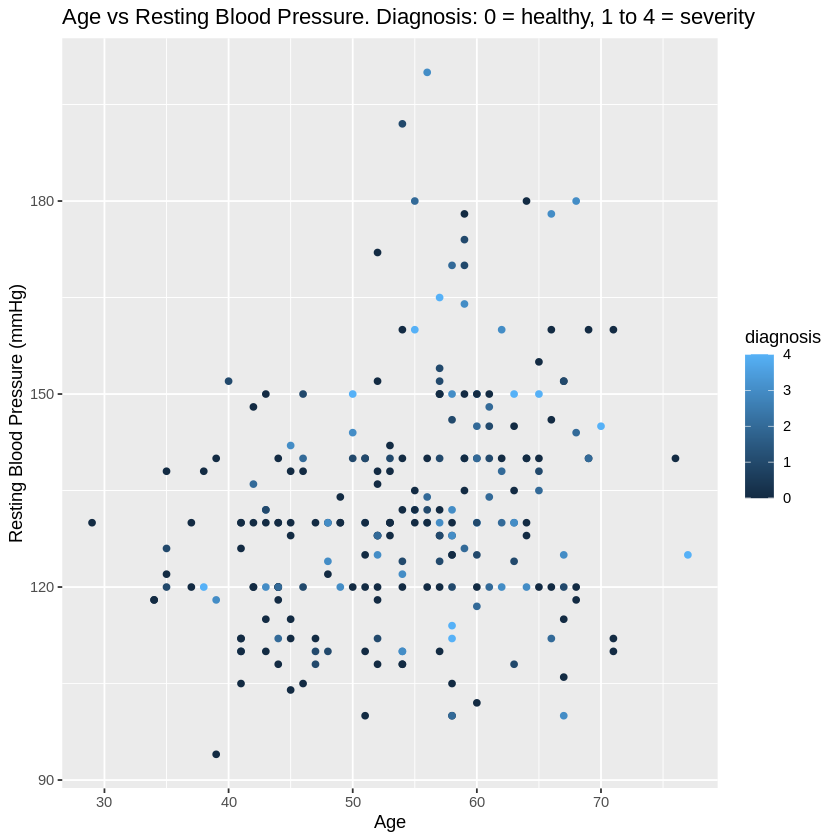

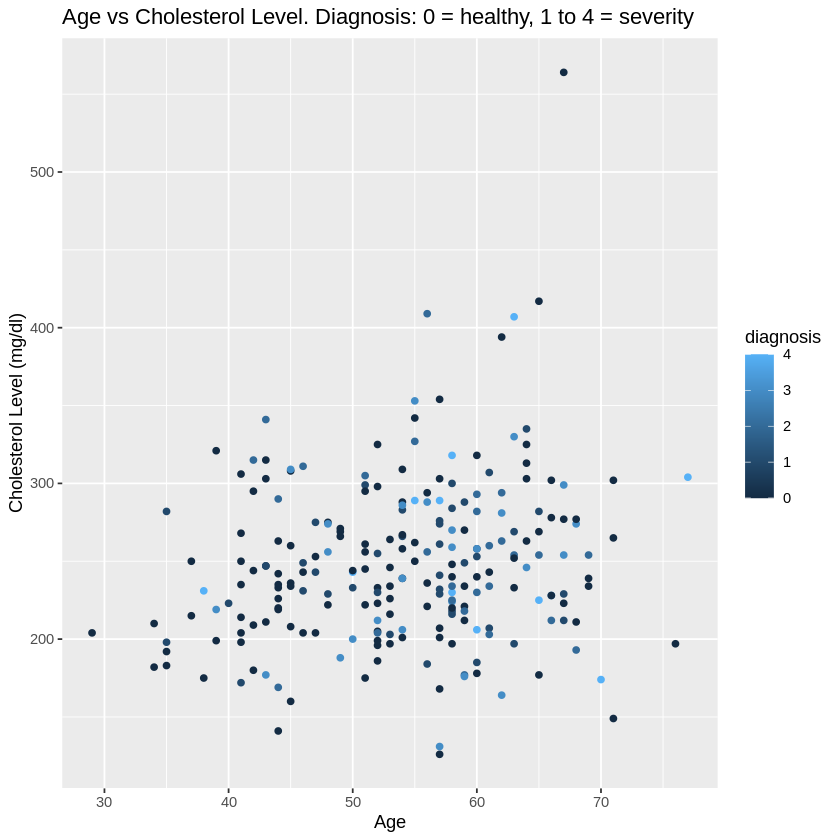

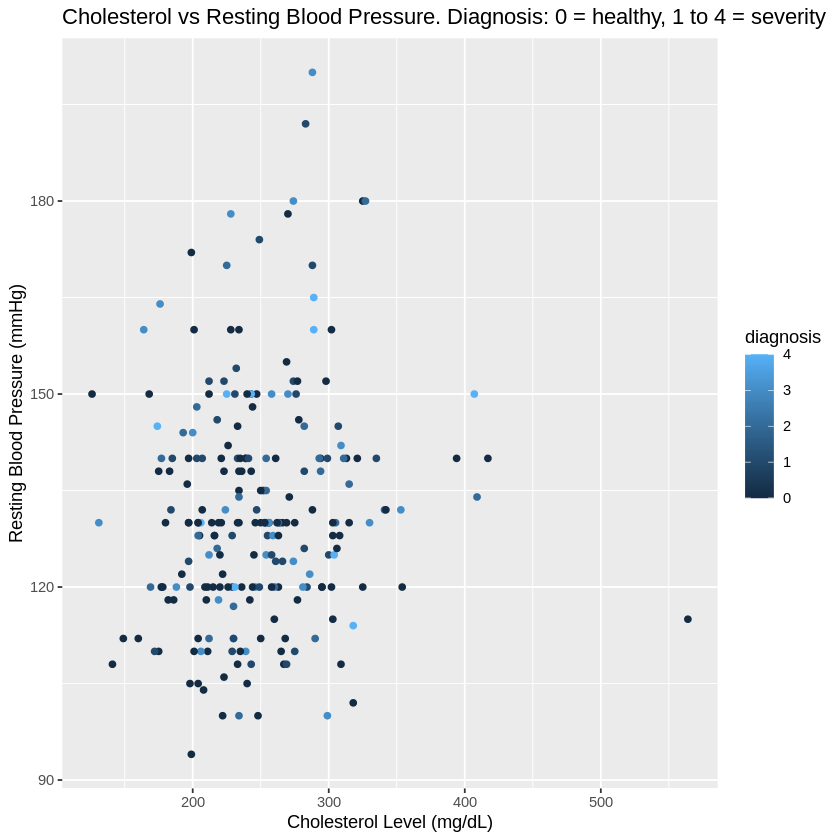

In [110]:
#Preliminary exploratory data analysis:

set.seed(9) 

heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

diagnosis_count <- heart_train %>%
group_by(diagnosis) %>%
summarize(n = n())
diagnosis_count

mean_age <- mean(heart_train$age)
standard_deviation_age <- sd(heart_train$age)

mean_resting_bp <- mean(heart_train$resting_blood_pressure)
standard_deviation_resting_bp <- sd(heart_train$resting_blood_pressure)

mean_cholesterol <- mean(heart_train$cholesterol_level)
standard_deviation_cholesterol <- sd(heart_train$cholesterol_level)

predictor_labels <- c('mean age', 'standard deviation age', 'mean resting bp', 'standard deviation resting bp', 'mean cholesterol', 'standard deviation cholesterol') %>%
data.frame() 
predictor_info <- c(mean_age, standard_deviation_age, mean_resting_bp, standard_deviation_resting_bp, mean_cholesterol, standard_deviation_cholesterol) %>%
data.frame() 
predictor_table <- cbind(predictor_labels, predictor_info)
predictor_table

age_vs_resting_bp_plot <- ggplot(heart_train, aes(x=age, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Age vs Resting Blood Pressure. Diagnosis: 0 = healthy, 1 to 4 = severity') 
age_vs_resting_bp_plot

age_vs_cholesterol_plot <- ggplot(heart_train, aes(x=age, y=cholesterol_level, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Cholesterol Level (mg/dl)') +
ggtitle('Age vs Cholesterol Level. Diagnosis: 0 = healthy, 1 to 4 = severity') 
age_vs_cholesterol_plot

cholesterol_vs_resting_bp_plot <- ggplot(heart_train, aes(x=cholesterol_level, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Cholesterol Level (mg/dL)') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Cholesterol vs Resting Blood Pressure. Diagnosis: 0 = healthy, 1 to 4 = severity')
cholesterol_vs_resting_bp_plot

CITATIONS:
1.	Damen, Johanna A, et al. “Prediction Models for Cardiovascular Disease Risk in the General Population: Systematic Review.” BMJ, 2016, p. i2416., https://doi.org/10.1136/bmj.i2416.
2.	“High Cholesterol.” Mayo Clinic, Mayo Foundation for Medical Education and Research, 20 July 2021, https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=With%20high%20cholesterol%2C%20you%20can,a%20heart%20attack%20or%20stroke.
3.	Weitzman, Dahlia, and Uri Goldbourt. “The Significance of Various Blood Pressure Indices for Long-Term Stroke, Coronary Heart Disease, and All-Cause Mortality in Men.” Stroke, vol. 37, no. 2, 2006, pp. 358–363., https://doi.org/10.1161/01.str.0000198869.84540.80. 
